# Image Preparation

In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sem.onyalo\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

Found 40 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [5]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
        f = plt.figure(figsize=figsize)
        cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
        for i in range(len(ims)):
            sp = f.add_subplot(rows, cols, i+1)
            sp.axis('Off')
            if titles is not None:
                sp.set_title(titles[i], fontsize=16)
            plt.imshow(ims[i], interpolation=None if interp else 'none')

In [6]:
imgs, labels = next(train_batches)

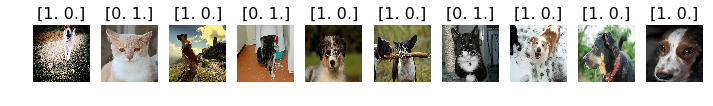

In [7]:
plots(imgs, titles=labels)

# Build and Train CNN

In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax')
])

In [9]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 3s - loss: 6.5506 - acc: 0.5500 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 2/5
 - 3s - loss: 6.8502 - acc: 0.5750 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 3/5
 - 3s - loss: 6.8502 - acc: 0.5750 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 4/5
 - 3s - loss: 6.8502 - acc: 0.5750 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 5/5
 - 3s - loss: 6.8502 - acc: 0.5750 - val_loss: 9.0664 - val_acc: 0.4375


# Predict

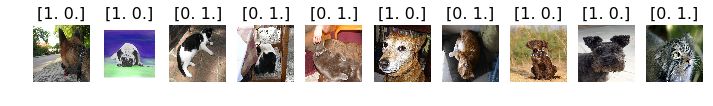

In [11]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [12]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)

In [13]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [14]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0]
 [4 1]]


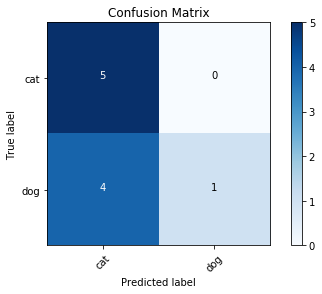

In [17]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Build Fine-Tuned VGG16 Model

In [18]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 440s 1us/step


In [19]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
type(vgg16_model)

keras.engine.training.Model

In [21]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
model.layers.pop()

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
for layer in model.layers:
    # do not update these layer's weights during training
    layer.trainable = False

In [26]:
model.add(Dense(2, activation='softmax'))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Train Fine-Tuned VGG16 Model

In [28]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 42s - loss: 0.6928 - acc: 0.5000 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 2/5
 - 48s - loss: 0.6856 - acc: 0.7500 - val_loss: 0.6894 - val_acc: 0.6875
Epoch 3/5
 - 42s - loss: 0.6796 - acc: 0.8500 - val_loss: 0.6853 - val_acc: 0.8125
Epoch 4/5
 - 50s - loss: 0.6737 - acc: 0.9000 - val_loss: 0.6812 - val_acc: 0.8750
Epoch 5/5
 - 51s - loss: 0.6691 - acc: 0.9000 - val_loss: 0.6774 - val_acc: 0.8750


# Predict Using Fine-Tuned VGG16 Model

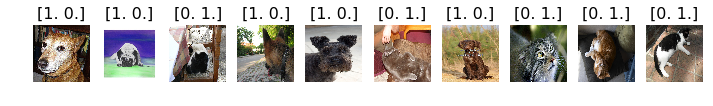

In [30]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [31]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 1., 1., 0., 1., 0., 0., 0.], dtype=float32)

In [32]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [33]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[4 1]
 [3 2]]


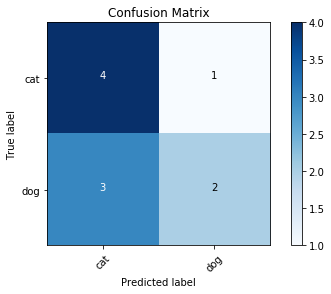

In [34]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')